<a href="https://colab.research.google.com/github/sinaziaee/paper_field_prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
print("PyTorch has version {}".format(torch.__version__))
# Install torch geometric
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html &> /dev/null
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.12.0+cu113.html &> /dev/null
!pip install -q torch-geometric &> /dev/null
!pip install ogb &> /dev/null
!pip install matplotlib==3.1.3 &> /dev/null
##
import torch_geometric
print(torch_geometric.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Dataset loader
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
dataset = PygNodePropPredDataset(name='ogbn-mag')
split_idx = dataset.get_idx_split()
data = dataset[0]
# data information
print(data)

PyTorch has version 1.12.1+cu113
2.1.0
ogbn-mag has been updated.
Will you update the dataset now? (y/N)
y


Downloaded 0.40 GB: 100%|██████████| 413/413 [00:16<00:00, 24.88it/s]


Extracting dataset/mag.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 5592.41it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 1651.30it/s]

Saving...



Done!


Data(
  num_nodes_dict={
    author=1134649,
    field_of_study=59965,
    institution=8740,
    paper=736389
  },
  edge_index_dict={
    (author, affiliated_with, institution)=[2, 1043998],
    (author, writes, paper)=[2, 7145660],
    (paper, cites, paper)=[2, 5416271],
    (paper, has_topic, field_of_study)=[2, 7505078]
  },
  x_dict={ paper=[736389, 128] },
  node_year={ paper=[736389, 1] },
  edge_reltype={
    (author, affiliated_with, institution)=[1043998, 1],
    (author, writes, paper)=[7145660, 1],
    (paper, cites, paper)=[5416271, 1],
    (paper, has_topic, field_of_study)=[7505078, 1]
  },
  y_dict={ paper=[736389, 1] }
)


In [11]:
no_paper = data.num_nodes_dict['paper']
no_study_fields = data.num_nodes_dict['field_of_study']
m_key = 'paper', 'has_topic', 'field_of_study'
no_paper_study_fields = data.edge_index_dict[m_key].shape[1]
print('no paper:', no_paper)
print('no study fields:', no_study_fields)
print('no paper study fields:', no_paper_study_fields)

no paper: 736389
no study fields: 59965
no paper study fields: 7505078


In [60]:
# selecting edges connected to field of studies
study_fields = data.edge_index_dict[m_key][1].numpy()
print(study_fields)
study_fields = list(study_fields)
study_fields_list = [0 for i in range(no_study_fields)]
for each in study_fields:
  study_fields_list[each] += 1
# number of papers with each field of studies
study_fields_list = np.array(study_fields_list)
print('number of papers for each study field: ', study_fields_list)

[  145  2215  3205 ... 21458 22283 31934]
number of papers for each study field:  [   7 1353  609 ...    2    1    1]


In [61]:
# creating a dictionary of papers and their corresponding fields of studies
papers_dict = dict(zip([i for i in range(no_paper)], [[] for i in range(no_paper)]))
for each in data.edge_index_dict[m_key].T.numpy():
  paper = each[0]
  field = each[1]
  papers_dict[paper].append(field)

16758 fields of study are used only in one paper. Field of study "14055" is used in all papers. 3 papers only have 14055 as their only field of study.
We will select the fields of study that are used in most number of papers. we will filter them based on fields that are used higher than 10000, 20000, ..., 50000 papers.

In [86]:
print(study_fields_list[study_fields_list==1].shape[0])

16758


In [87]:
study_fields_list

(59965,)

In [62]:
print(study_fields_list[study_fields_list>50000])
print('field of study with the maximum number of papers: ', study_fields_list.argmax())
field_of_study_with_max_papers = study_fields_list.argmax()

[ 87464 129205  96621  86355  70668  67323 189963 736389  71231]
field of study with the maximum number of papers:  14055


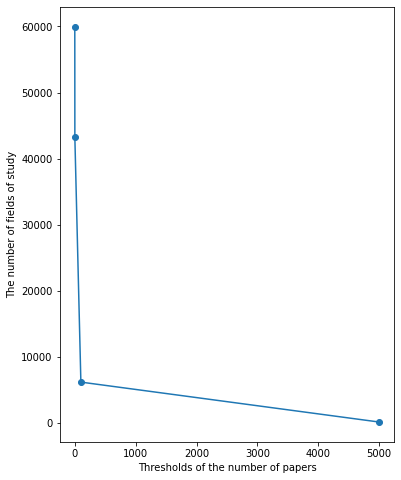


number of papers:     [0, 1, 100, 5000]
number of study fields: [59965, 43207, 6215, 177]


In [94]:
# selecting threshold list for visualization of the number of papers in each field of study
# threshold_list = [i * 10000 for i in range(6)]
threshold_list = [0, 1, 100, 5000]
result_list = []
# finding the number of papers on each threshold
for each in threshold_list:
  result_list.append(study_fields_list[study_fields_list>each].shape[0])
# visualization
plt.figure(figsize=(6, 8))
plt.scatter(threshold_list[:], result_list[:])
plt.plot(threshold_list[:], result_list[:])
plt.xlabel('Thresholds of the number of papers')
plt.ylabel('The number of fields of study')
# for i in range(len(result_list)):
#     plt.annotate(result_list[i], (threshold_list[i], result_list[i] + 0.2))
plt.show()
print(f'\nnumber of papers:     {threshold_list}')
print(f'number of study fields: {result_list}')

In [64]:
keys = [i for i in range(no_study_fields)] # study fields
values = list(study_fields_list) # number of papers
study_fields_dict = dict(zip(keys, values))
sorted_dict = dict(sorted(study_fields_dict.items(), key=lambda item: item[1]))

In [98]:
def find_field_with_max_no_papers(temp_dict, study_fields_list_in_each_paper):
  temp_list = []
  # removing the most used field of study (14055)
  if len(study_fields_list_in_each_paper) == 1: # if the list only has 14055 as study field then return it, otherwise find the next max field
    # print(study_fields_list_in_each_paper)
    return field_of_study_with_max_papers
  study_fields_list_in_each_paper.remove(field_of_study_with_max_papers)
  # find the order (higher number -> higer priority)
  for field in study_fields_list_in_each_paper:
    temp_list.append(temp_dict[field])
  # finding the study field with maximum number of papers
  maximum = max(temp_list)
  # finding it's index
  max_index = temp_list.index(maximum)
  # returning the field of study itself (not the index)
  study_field_with_max_no_papers = study_fields_list_in_each_paper[max_index]
  return study_field_with_max_no_papers

In [99]:
papers_study_fields = [field_of_study_with_max_papers for i in range(no_paper)]
temp_dict = dict(zip(list(sorted_dict.keys()), [i for i in range(len(list(sorted_dict.keys())))]))
# find the most used field of study
for i in range(no_paper):
  study_fields_list_in_each_paper = papers_dict[i][:]
  study_field_with_max_no_papers = find_field_with_max_no_papers(temp_dict, study_fields_list_in_each_paper) 
  papers_study_fields[i] = study_field_with_max_no_papers
# saving the result as it may take a while
papers_study_fields = np.array(papers_study_fields)
np.savetxt('saved_list.txt', papers_study_fields, fmt='%d')
b = np.loadtxt('saved_list.txt', dtype=int)
# automatically downloading the result
# from google.colab import files
# files.download('saved_list.txt') 

In [103]:
temp_set = set()
for each in list(papers_study_fields):
  temp_set.add(each)

In [107]:
my_dict = dict(zip(list(temp_set), [0 for i in range(len(temp_set))]))
for each in list(papers_study_fields):
  my_dict[each]+=1

In [124]:
new_y = torch.from_numpy(papers_study_fields.reshape((papers_study_fields.shape[0], 1)))
data.y_dict['paper'] = new_y